In [1]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
import torch
from diffusers.utils import load_image
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
import numpy as np

DEVICE = torch.device('cuda:0')

ModuleNotFoundError: No module named 'diffusers'

In [ ]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    'kandinsky-community/kandinsky-2-2-prior',
    subfolder='image_encoder'
).half().to(DEVICE)

In [ ]:
unet = UNet2DConditionModel.from_pretrained(
    'kandinsky-community/kandinsky-2-2-decoder',
    subfolder='unet'
).half().to(DEVICE)

In [ ]:
prior = KandinskyV22PriorPipeline.from_pretrained(
    'kandinsky-community/kandinsky-2-2-prior',
    image_encoder=image_encoder,
    torch_dtype=torch.float16
).to(DEVICE)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 6/6 [00:14<00:00,  2.47s/it]


In [ ]:
decoder = KandinskyV22Pipeline.from_pretrained(
    'kandinsky-community/kandinsky-2-2-decoder',
    unet=unet,
    torch_dtype=torch.float16
).to(DEVICE)

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  4.34it/s]


In [7]:
torch.manual_seed(42)

negative_prior_prompt ='lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature'
negative_prior_prompt = 'low quality, bad quality'

img_emb = prior(
    prompt='big bag with entering room with clown with me, interstring, atmospheric, many words, many cocks, many rocks, many boobs, many people, many kicks, disney, pixar, ea sports, dotnet, c++, clownish, british, european union, programmer, complicated, overall, international, music, pitbull, dogs, cats, rats, racoons, nature, family, fast and furious like, century, film, am i too clownish right now, is it gonna end sometime, what the hell man stop please already you clown stop stop',
    num_inference_steps=250,
    num_images_per_prompt=1
)

negative_emb = prior(
    prompt=negative_prior_prompt,
    num_inference_steps=250,
    num_images_per_prompt=1
)

images = decoder(
    image_embeds=img_emb.image_embeds,
    negative_image_embeds=negative_emb.image_embeds,
    num_inference_steps=250,
    guidance_scale=4.0,
    height=380,
    width=720)

100%|██████████| 250/250 [00:18<00:00, 13.30it/s]


In [8]:
type(images.images[0])

PIL.Image.Image

In [10]:
PIL.Image.Image

PIL.Image.Image

In [ ]:
images.images[0]

In [4]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to('cuda:0')

In [7]:
def generate_desc(processor, model, filename):
    raw_image = Image.open(filename).convert('RGB')

    # conditional image captioning
    text = "a photography of"
    inputs = processor(raw_image, text, return_tensors="pt").to('cuda:0')

    out = model.generate(**inputs)
    print(processor.decode(out[0], skip_special_tokens=True))

    # unconditional image captioning
    inputs = processor(raw_image, return_tensors="pt").to('cuda:0')

    out = model.generate(**inputs)
    print(processor.decode(out[0], skip_special_tokens=True))


In [8]:
generate_desc(processor, model, 'ph.jpg')

/home/prof_evaluation/miniconda3/envs/aino-latest/lib/python3.9/site-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a photography of a cat playing with a wooden table with bowls of food
there is a cat that is playing with a wooden table


In [1]:
from diffusers.utils import load_image

img = load_image(
    "/home/ubuntu/funny_portrait_of_an_racoon_AH5I5YwSsv.jpg"
).resize((768, 768))

import torch
import numpy as np

from transformers import pipeline
from diffusers.utils import load_image


def make_hint(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    hint = detected_map.permute(2, 0, 1)
    return hint


depth_estimator = pipeline("depth-estimation")
hint = make_hint(img, depth_estimator).unsqueeze(0).half().to("cuda")

from diffusers import KandinskyV22PriorPipeline, KandinskyV22ControlnetPipeline

pipe_prior = KandinskyV22PriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16
)
pipe_prior = pipe_prior.to("cuda")

pipe = KandinskyV22ControlnetPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-controlnet-depth", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

prompt = "A robot, 4k photo"

negative_prior_prompt = "lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"

generator = torch.Generator(device="cuda").manual_seed(43)
image_emb, zero_image_emb = pipe_prior(
    prompt=prompt, negative_prompt=negative_prior_prompt, generator=generator
).to_tuple()

/home/ubuntu/anaconda/envs/aino-latest/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find

In [2]:
width, height = img.size

images = pipe(
    image_embeds=image_emb,
    negative_image_embeds=zero_image_emb,
    hint=hint,
    num_inference_steps=50,
    generator=generator,
    height=height,
    width=width,
).images

100%|██████████| 50/50 [00:06<00:00,  7.50it/s]


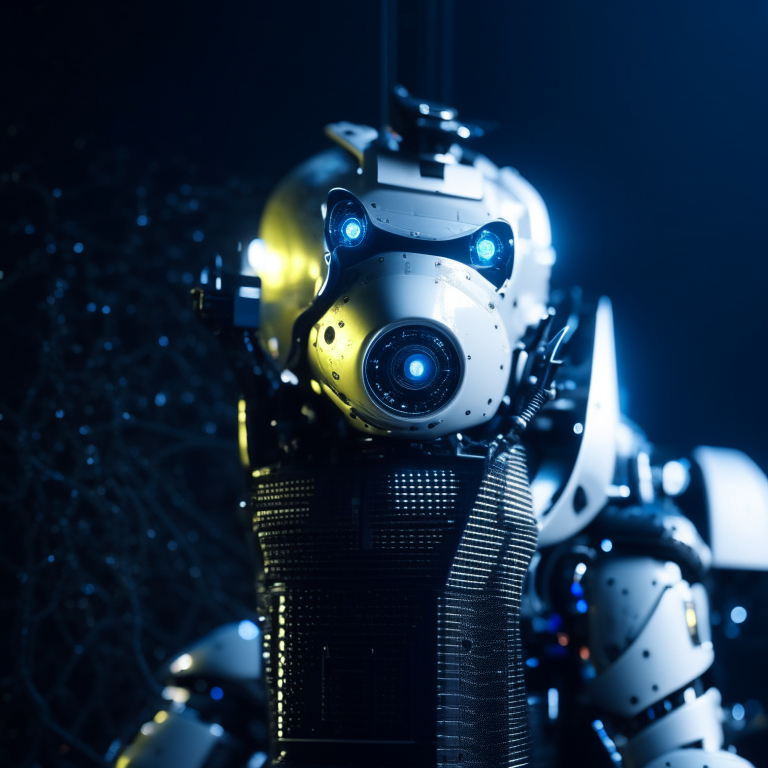

In [3]:
images[0]